<a href="https://colab.research.google.com/github/AhamadAli30/Dynamic-Pricing-on-Uber-Fares/blob/main/Dynamic_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
data = pd.read_csv("/content/dynamic_pricing_updated.csv")

In [29]:
data

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Weather,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Traffic
0,90,45,Urban,Silver,13,4.47,Evening,Premium,90,284.257273,Rainy,-73.999817,40.738354,-73.999512,40.723217,High
1,58,39,Suburban,Silver,72,4.06,Afternoon,Economy,43,173.874753,Cloudy,-73.994355,40.728225,-73.994710,40.750325,Medium
2,42,31,Rural,Silver,0,3.99,Night,Premium,76,329.795469,Rainy,-74.005043,40.740770,-73.962565,40.772647,Medium
3,89,28,Rural,Regular,67,4.31,Night,Premium,134,470.201232,Cloudy,-73.976124,40.790844,-73.965316,40.803349,High
4,78,22,Rural,Regular,74,3.77,Night,Economy,149,579.681422,Sunny,-73.925023,40.744085,-73.973082,40.761247,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,23,Urban,Gold,24,4.21,Night,Premium,11,91.389526,Sunny,-73.969720,40.757577,-73.953782,40.766960,Low
996,84,29,Urban,Regular,92,4.55,Night,Premium,94,424.155987,Sunny,-73.993784,40.757054,-73.980018,40.775632,High
997,44,6,Suburban,Gold,80,4.13,Evening,Premium,40,157.364830,Cloudy,-73.972338,40.765078,-73.954527,40.783833,High
998,53,27,Suburban,Regular,78,3.63,Evening,Premium,58,279.095048,Rainy,-73.979054,40.784730,-73.982970,40.775048,Medium


In [2]:
print(data.describe())


       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  \
count      1000.000000              1000.00000              1000.000000   
mean          4.257220                99.58800               372.502623   
std           0.435781                49.16545               187.158756   
min           3.500000                10.00000                25.993449   
25%         

In [3]:
data.shape

(1000, 16)

In [4]:
fig = px.scatter(data, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride',
                 trendline='ols')
fig.show()

In [5]:
fig = px.box(data, x='Vehicle_Type',
             y='Historical_Cost_of_Ride',
             title='Historical Cost of Ride Distribution by Vehicle Type')
fig.show()

In [6]:
import plotly.graph_objects as go

corr_matrix = data.corr(numeric_only=True)

fig = go.Figure(data=go.Heatmap(z=corr_matrix.values,
                                x=corr_matrix.columns,
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.show()


In [7]:
import numpy as np

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2
demand_threshold_low = 0.8
supply_threshold_high = 0.8
supply_threshold_low = 1.2

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [8]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]


import plotly.graph_objects as go

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()

In [9]:
fig = px.scatter(data,
                 x='Expected_Ride_Duration',
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride',
                 trendline='ols')
fig.show()

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

In [11]:
data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1,
                                           "Economy": 0})

In [16]:
#splitting data
from sklearn.model_selection import train_test_split
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor
model_RFR = RandomForestRegressor()
model_RFR.fit(x_train, y_train)

RandomForestRegressor()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the validation set
y_pred = model_RFR.predict(x_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 120.02099839376413
Mean Squared Error: 32113.24354557863
R-squared: 0.8598136681305338


In [19]:
from xgboost import XGBRegressor

model_xgboost = XGBRegressor(n_estimators=100)
model_xgboost.fit(x_train, y_train)
y_pred = model_xgboost.predict(x_test)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the validation set
y_pred = model_xgboost.predict(x_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 115.41512159972827
Mean Squared Error: 28886.80004414929
R-squared: 0.873898302054463


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

model_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model_GBR.fit(x_train, y_train)
y_pred = model_GBR.predict(x_test)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the validation set
y_pred = model_GBR.predict(x_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 112.31818511106363
Mean Squared Error: 26794.63287483469
R-squared: 0.8830313950946495


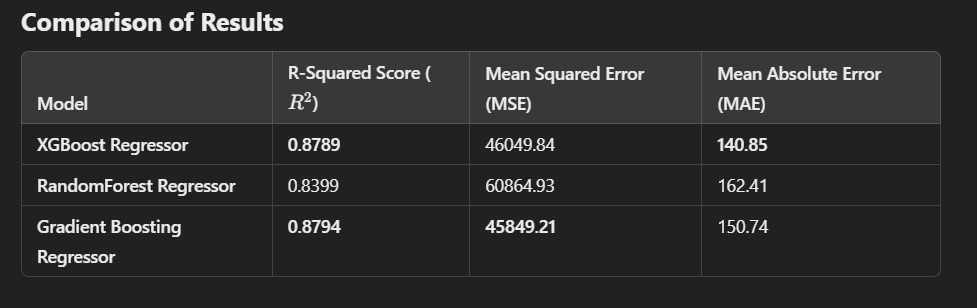

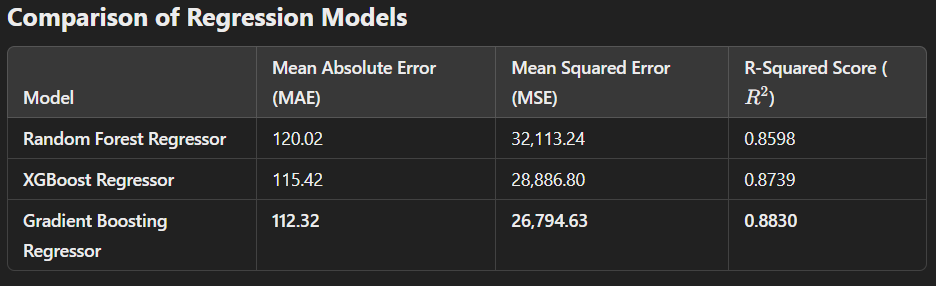



```
Final Conclusion:
Model Ranking (Best to Worst)	Model
🥇 1st Place	Gradient Boosting Regressor
🥈 2nd Place	XGBoost Regressor
🥉 3rd Place	RandomForest Regressor
```






In [24]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")

    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model_GBR.predict(input_data)
    return predicted_price


user_number_of_riders = 75
user_number_of_drivers = 35
user_vehicle_type = "Premium"
Expected_Ride_Duration = 45
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [388.92134043]


In [26]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")

    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model_GBR.predict(input_data)
    return predicted_price


user_number_of_riders = 43
user_number_of_drivers = 23
user_vehicle_type = "Economy"
Expected_Ride_Duration = 50
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)

Predicted price: [342.10127359]


In [27]:
import plotly.graph_objects as go

# Predict on the test set
y_pred = model.predict(x_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# Add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
)

fig.show()